In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Define transformation
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


In [2]:
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(256, 128 * 8 * 8)
        self.conv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = x.view(-1, 128, 8, 8)
        x = F.relu(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        return x

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.fc2 = nn.Linear(256, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 128 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
# Initialize networks
generator = Generator().to(device)
discriminator = Discriminator().to(device)

cuda


In [3]:
import torch.optim as optim
from tqdm import tqdm

# Hyperparameters
lr = 0.001
epochs = 50

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Loss function
criterion = nn.BCEWithLogitsLoss()

# Training loop
for epoch in range(epochs):
    generator.train()
    discriminator.train()
    loop = tqdm(train_loader, leave=True)
    for data in loop:
        inputs, _ = data
        inputs = inputs.to(device)
        batch_size = inputs.size(0)

        # Generate noise and real labels
        noise = torch.randn(batch_size, 100).to(device)
        real_labels = torch.ones(batch_size, 1).to(device) * 0.9  # Label smoothing
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Discriminator
        optimizer_D.zero_grad()
        outputs_real = discriminator(inputs)
        loss_real = criterion(outputs_real, real_labels)

        fake_images = generator(noise)
        outputs_fake = discriminator(fake_images.detach())
        loss_fake = criterion(outputs_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optimizer_D.step()

        # Train Generator
        optimizer_G.zero_grad()
        outputs_fake = discriminator(fake_images)
        loss_G = criterion(outputs_fake, real_labels)
        loss_G.backward()
        optimizer_G.step()

        # Update tqdm loop description with the current losses
        loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
        loop.set_postfix(loss_D=loss_D.item(), loss_G=loss_G.item())

    print(f"Epoch [{epoch+1}/{epochs}], Loss D: {loss_D.item():.4f}, Loss G: {loss_G.item():.4f}")

Epoch [1/50]: 100%|██████████| 782/782 [00:25<00:00, 30.88it/s, loss_D=0.493, loss_G=3.74]


Epoch [1/50], Loss D: 0.4930, Loss G: 3.7435


Epoch [2/50]: 100%|██████████| 782/782 [00:21<00:00, 35.63it/s, loss_D=0.568, loss_G=3.3] 


Epoch [2/50], Loss D: 0.5682, Loss G: 3.2966


Epoch [3/50]: 100%|██████████| 782/782 [00:21<00:00, 36.02it/s, loss_D=0.745, loss_G=2.35]


Epoch [3/50], Loss D: 0.7450, Loss G: 2.3495


Epoch [4/50]: 100%|██████████| 782/782 [00:22<00:00, 35.22it/s, loss_D=0.71, loss_G=3.73] 


Epoch [4/50], Loss D: 0.7098, Loss G: 3.7330


Epoch [5/50]: 100%|██████████| 782/782 [00:21<00:00, 35.93it/s, loss_D=0.445, loss_G=4.84]


Epoch [5/50], Loss D: 0.4452, Loss G: 4.8373


Epoch [6/50]: 100%|██████████| 782/782 [00:22<00:00, 35.46it/s, loss_D=0.555, loss_G=3.12]


Epoch [6/50], Loss D: 0.5545, Loss G: 3.1160


Epoch [7/50]: 100%|██████████| 782/782 [00:21<00:00, 35.94it/s, loss_D=0.598, loss_G=3.08]


Epoch [7/50], Loss D: 0.5976, Loss G: 3.0809


Epoch [8/50]: 100%|██████████| 782/782 [00:21<00:00, 35.88it/s, loss_D=0.54, loss_G=3.25] 


Epoch [8/50], Loss D: 0.5396, Loss G: 3.2451


Epoch [9/50]: 100%|██████████| 782/782 [00:21<00:00, 36.10it/s, loss_D=0.886, loss_G=5.64]


Epoch [9/50], Loss D: 0.8861, Loss G: 5.6399


Epoch [10/50]: 100%|██████████| 782/782 [00:21<00:00, 35.98it/s, loss_D=0.686, loss_G=3.14]


Epoch [10/50], Loss D: 0.6861, Loss G: 3.1407


Epoch [11/50]: 100%|██████████| 782/782 [00:21<00:00, 35.82it/s, loss_D=0.734, loss_G=2.09]


Epoch [11/50], Loss D: 0.7344, Loss G: 2.0890


Epoch [12/50]: 100%|██████████| 782/782 [00:21<00:00, 35.56it/s, loss_D=0.612, loss_G=3.44]


Epoch [12/50], Loss D: 0.6124, Loss G: 3.4377


Epoch [13/50]: 100%|██████████| 782/782 [00:21<00:00, 35.97it/s, loss_D=0.578, loss_G=2.99]


Epoch [13/50], Loss D: 0.5783, Loss G: 2.9863


Epoch [14/50]: 100%|██████████| 782/782 [00:21<00:00, 36.18it/s, loss_D=0.562, loss_G=4.58]


Epoch [14/50], Loss D: 0.5618, Loss G: 4.5778


Epoch [15/50]: 100%|██████████| 782/782 [00:22<00:00, 34.54it/s, loss_D=0.543, loss_G=2.68]


Epoch [15/50], Loss D: 0.5434, Loss G: 2.6844


Epoch [16/50]: 100%|██████████| 782/782 [00:21<00:00, 35.72it/s, loss_D=0.467, loss_G=3.44]


Epoch [16/50], Loss D: 0.4670, Loss G: 3.4424


Epoch [17/50]: 100%|██████████| 782/782 [00:21<00:00, 36.13it/s, loss_D=0.688, loss_G=3.05]


Epoch [17/50], Loss D: 0.6877, Loss G: 3.0519


Epoch [18/50]: 100%|██████████| 782/782 [00:21<00:00, 36.10it/s, loss_D=0.657, loss_G=2.71]


Epoch [18/50], Loss D: 0.6570, Loss G: 2.7089


Epoch [19/50]: 100%|██████████| 782/782 [00:21<00:00, 35.94it/s, loss_D=0.47, loss_G=3.75] 


Epoch [19/50], Loss D: 0.4704, Loss G: 3.7533


Epoch [20/50]: 100%|██████████| 782/782 [00:21<00:00, 36.20it/s, loss_D=0.557, loss_G=3.75]


Epoch [20/50], Loss D: 0.5571, Loss G: 3.7508


Epoch [21/50]: 100%|██████████| 782/782 [00:21<00:00, 36.17it/s, loss_D=0.585, loss_G=2.51]


Epoch [21/50], Loss D: 0.5845, Loss G: 2.5126


Epoch [22/50]: 100%|██████████| 782/782 [00:21<00:00, 36.15it/s, loss_D=0.473, loss_G=4.65]


Epoch [22/50], Loss D: 0.4733, Loss G: 4.6485


Epoch [23/50]: 100%|██████████| 782/782 [00:21<00:00, 35.72it/s, loss_D=0.499, loss_G=2.7] 


Epoch [23/50], Loss D: 0.4986, Loss G: 2.6970


Epoch [24/50]: 100%|██████████| 782/782 [00:23<00:00, 33.93it/s, loss_D=0.558, loss_G=3.14]


Epoch [24/50], Loss D: 0.5583, Loss G: 3.1389


Epoch [25/50]: 100%|██████████| 782/782 [00:21<00:00, 35.88it/s, loss_D=0.573, loss_G=3.28]


Epoch [25/50], Loss D: 0.5725, Loss G: 3.2841


Epoch [26/50]: 100%|██████████| 782/782 [00:21<00:00, 35.61it/s, loss_D=0.472, loss_G=2.73]


Epoch [26/50], Loss D: 0.4721, Loss G: 2.7313


Epoch [27/50]: 100%|██████████| 782/782 [00:21<00:00, 36.05it/s, loss_D=0.877, loss_G=2.96]


Epoch [27/50], Loss D: 0.8767, Loss G: 2.9564


Epoch [28/50]: 100%|██████████| 782/782 [00:21<00:00, 36.22it/s, loss_D=0.745, loss_G=2.81]


Epoch [28/50], Loss D: 0.7449, Loss G: 2.8068


Epoch [29/50]: 100%|██████████| 782/782 [00:21<00:00, 35.78it/s, loss_D=0.516, loss_G=3.31]


Epoch [29/50], Loss D: 0.5165, Loss G: 3.3086


Epoch [30/50]: 100%|██████████| 782/782 [00:21<00:00, 35.94it/s, loss_D=0.554, loss_G=2.69]


Epoch [30/50], Loss D: 0.5537, Loss G: 2.6880


Epoch [31/50]: 100%|██████████| 782/782 [00:21<00:00, 36.11it/s, loss_D=0.964, loss_G=2.82]


Epoch [31/50], Loss D: 0.9638, Loss G: 2.8164


Epoch [32/50]: 100%|██████████| 782/782 [00:22<00:00, 35.42it/s, loss_D=0.739, loss_G=3.19]


Epoch [32/50], Loss D: 0.7385, Loss G: 3.1898


Epoch [33/50]: 100%|██████████| 782/782 [00:21<00:00, 36.05it/s, loss_D=0.804, loss_G=1.99]


Epoch [33/50], Loss D: 0.8036, Loss G: 1.9931


Epoch [34/50]: 100%|██████████| 782/782 [00:21<00:00, 36.18it/s, loss_D=0.72, loss_G=2.53] 


Epoch [34/50], Loss D: 0.7202, Loss G: 2.5284


Epoch [35/50]: 100%|██████████| 782/782 [00:21<00:00, 35.69it/s, loss_D=0.719, loss_G=2.22]


Epoch [35/50], Loss D: 0.7190, Loss G: 2.2181


Epoch [36/50]: 100%|██████████| 782/782 [00:21<00:00, 36.13it/s, loss_D=0.962, loss_G=2.94]


Epoch [36/50], Loss D: 0.9622, Loss G: 2.9444


Epoch [37/50]: 100%|██████████| 782/782 [00:22<00:00, 35.26it/s, loss_D=0.773, loss_G=2.85]


Epoch [37/50], Loss D: 0.7726, Loss G: 2.8476


Epoch [38/50]: 100%|██████████| 782/782 [00:22<00:00, 35.15it/s, loss_D=0.842, loss_G=1.78]


Epoch [38/50], Loss D: 0.8420, Loss G: 1.7801


Epoch [39/50]: 100%|██████████| 782/782 [00:21<00:00, 35.60it/s, loss_D=0.628, loss_G=2.65]


Epoch [39/50], Loss D: 0.6281, Loss G: 2.6545


Epoch [40/50]: 100%|██████████| 782/782 [00:21<00:00, 35.91it/s, loss_D=0.821, loss_G=2.39]


Epoch [40/50], Loss D: 0.8213, Loss G: 2.3938


Epoch [41/50]: 100%|██████████| 782/782 [00:21<00:00, 35.82it/s, loss_D=0.654, loss_G=2.45]


Epoch [41/50], Loss D: 0.6542, Loss G: 2.4489


Epoch [42/50]: 100%|██████████| 782/782 [00:21<00:00, 35.96it/s, loss_D=0.841, loss_G=2.36]


Epoch [42/50], Loss D: 0.8406, Loss G: 2.3565


Epoch [43/50]: 100%|██████████| 782/782 [00:21<00:00, 36.19it/s, loss_D=0.704, loss_G=3.2] 


Epoch [43/50], Loss D: 0.7041, Loss G: 3.1985


Epoch [44/50]: 100%|██████████| 782/782 [00:21<00:00, 35.82it/s, loss_D=0.899, loss_G=1.82]


Epoch [44/50], Loss D: 0.8993, Loss G: 1.8187


Epoch [45/50]: 100%|██████████| 782/782 [00:21<00:00, 35.91it/s, loss_D=0.793, loss_G=2.01]


Epoch [45/50], Loss D: 0.7933, Loss G: 2.0073


Epoch [46/50]: 100%|██████████| 782/782 [00:21<00:00, 36.17it/s, loss_D=0.693, loss_G=2.4] 


Epoch [46/50], Loss D: 0.6929, Loss G: 2.4027


Epoch [47/50]: 100%|██████████| 782/782 [00:21<00:00, 36.01it/s, loss_D=0.403, loss_G=5.12]


Epoch [47/50], Loss D: 0.4030, Loss G: 5.1159


Epoch [48/50]: 100%|██████████| 782/782 [00:21<00:00, 36.10it/s, loss_D=0.464, loss_G=4.44]


Epoch [48/50], Loss D: 0.4638, Loss G: 4.4389


Epoch [49/50]: 100%|██████████| 782/782 [00:21<00:00, 35.89it/s, loss_D=0.551, loss_G=2.74]


Epoch [49/50], Loss D: 0.5513, Loss G: 2.7353


Epoch [50/50]: 100%|██████████| 782/782 [00:21<00:00, 36.14it/s, loss_D=0.652, loss_G=2.63]

Epoch [50/50], Loss D: 0.6523, Loss G: 2.6269


In [4]:
# Function to calculate accuracy
def calculate_accuracy(loader):
    discriminator.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data in loader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = discriminator(inputs)
            predicted = (outputs > 0.5).float()  # Threshold the outputs to determine if they are real or fake
            total += labels.size(0)
            correct += (predicted.squeeze() == labels).sum().item()
    return 100 * correct / total

# Calculate accuracy on the test set
accuracy = calculate_accuracy(test_loader)
print(f"Accuracy on the test set: {accuracy:.2f}%")

Accuracy on the test set: 10.13%


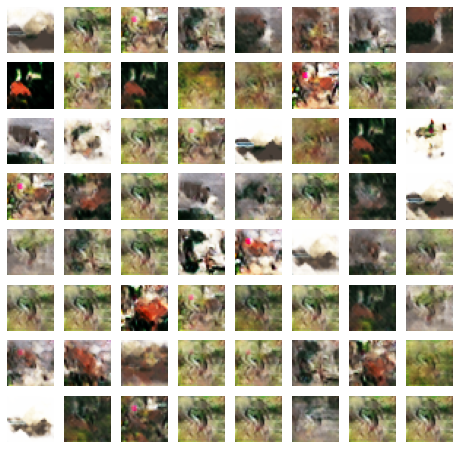

In [5]:
import matplotlib.pyplot as plt

# Generate images
generator.eval()
with torch.no_grad():
    noise = torch.randn(64, 100).to(device)
    generated_images = generator(noise)

# Function to visualize generated images
def show_images(images, num_images=64):
    images = images / 2 + 0.5  # Unnormalize from [-1, 1] to [0, 1]
    plt.figure(figsize=(8, 8))
    for i in range(num_images):
        plt.subplot(8, 8, i+1)
        plt.imshow(images[i].permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
    plt.show()

show_images(generated_images)